In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [ ]:
# 주식 데이터를 불러오기
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# 시작일과 종료일 설정
start = datetime(2020, 1, 1)
end = datetime.now()

# # 각각의 종목 데이터를 불러와서 CSV 파일로 저장
# for stock in tech_list:
#     data = yf.download(stock, start=start, end=end)
#     data.to_csv(f'{stock}_data.csv')  # CSV 파일로 저장
#     print(f"\n{stock} 데이터를 {stock}_data.csv 파일로 저장했습니다.")

In [ ]:
column_names = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

AAPL = pd.read_csv(r'C:\Users\a\Desktop\mini_project\15_stock_predict\AAPL_data.csv', 
                   skiprows=2,           # 첫 번째 두 행 스킵
                   names=column_names,   # 칼럼명 지정
                   index_col=0,           # 'Date' 열을 인덱스로 설정
                   parse_dates=True) 

AAPL_ = AAPL.dropna()

In [ ]:
AAPL_.head(5)

In [ ]:
AAPL_.info()

In [ ]:
import matplotlib.dates as mdates  # 날짜 형식 지정을 위해 필요

AAPL_.index = pd.to_datetime(AAPL_.index)

plt.style.use('seaborn')

plt.figure(figsize=(10, 6))


plt.plot(AAPL_['Adj Close'], 
         color='#1f77b4',
         linewidth=1.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # 6개월 간격으로 눈금 설정
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m'))  # YYYY.MM 형식으로 표시

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Volume', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(bottom=0)

plt.xticks(rotation=0)

plt.tight_layout()

plt.show()

In [ ]:
'''
model, scaler, rmse = prepare_and_train_model(df)
'''

In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim

- 데이터를 12년도 부터 24년도까지 

In [5]:
aapl = yf.download('AAPL', start='2012-01-01', end=datetime.now(), interval='1d')
aapl.columns = aapl.columns.droplevel(1)
aapl = aapl[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
aapl.reset_index(inplace=True)
aapl['Date'] = aapl['Date'].dt.strftime('%Y-%m-%d 00:00:00-05:00')
aapl.set_index('Date', inplace=True)

[*********************100%***********************]  1 of 1 completed


- 95%를 훈련데이터 사용, 5%는 검증 데이터로 사용 
- 예측은 종가 ['close']만 사용 
- 

In [6]:
df = aapl
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))

In [7]:
df.tail()

Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-18 00:00:00-05:00,236.179993,236.179993,234.009995,235.000000,235.000000,46431500
2024-10-21 00:00:00-05:00,234.449997,236.850006,234.449997,236.479996,236.479996,36254500
2024-10-22 00:00:00-05:00,233.889999,236.220001,232.600006,235.860001,235.860001,38846600
2024-10-23 00:00:00-05:00,234.080002,235.139999,227.759995,230.759995,230.759995,52287000
2024-10-24 00:00:00-05:00,229.979996,230.820007,228.410004,230.570007,230.570007,31071100


- 데이터 스케일링 
- 앞서 서장한 traing_data_len을 활용하여 train_data로 저장하고 스케일링

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [9]:
train_data = scaled_data[0:int(training_data_len), :]

- LSTM 예측을 위해 사용할 시퀸스 길이는 60으로 설정
- i에서 60개 이전이 x_train / i부터 60개를 예상해야하는 y_train으로 설정 
- x_train => 샘플 수, 시퀀스 길이, 특성 수 
- 즉 60일의 데이터를 기반으로 다음 날의 주가를 예측하는 구조

In [10]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

- 데이터셋 및 데이터로더

In [11]:
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

In [12]:
train_dataset = StockDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

- 테스트 데이터 만들기

In [13]:
test_data = scaled_data[training_data_len - 60:, :] # 훈련 데이터 이후 데이터 
x_test = []
y_test = dataset[training_data_len:, :] # x_test데이터 60일이후  종가 데이터

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dense1 = nn.Linear(64, 25)
        self.dense2 = nn.Linear(25, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.dense1(out[:, -1, :])
        out = self.dense2(out)
        return out

- 모델 학습
- 시간이 없으므로 에포크는 1만

In [15]:
model = LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

- 예측 수행 

In [16]:
model.eval()
with torch.no_grad():
    x_test_tensor = torch.FloatTensor(x_test)
    predictions = model(x_test_tensor)
    predictions = scaler.inverse_transform(predictions.numpy())

- 예측을 데이터 프레임으로 만들고 확인

In [17]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\a\AppData\Local\Temp\ipykernel_16200\2657761684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


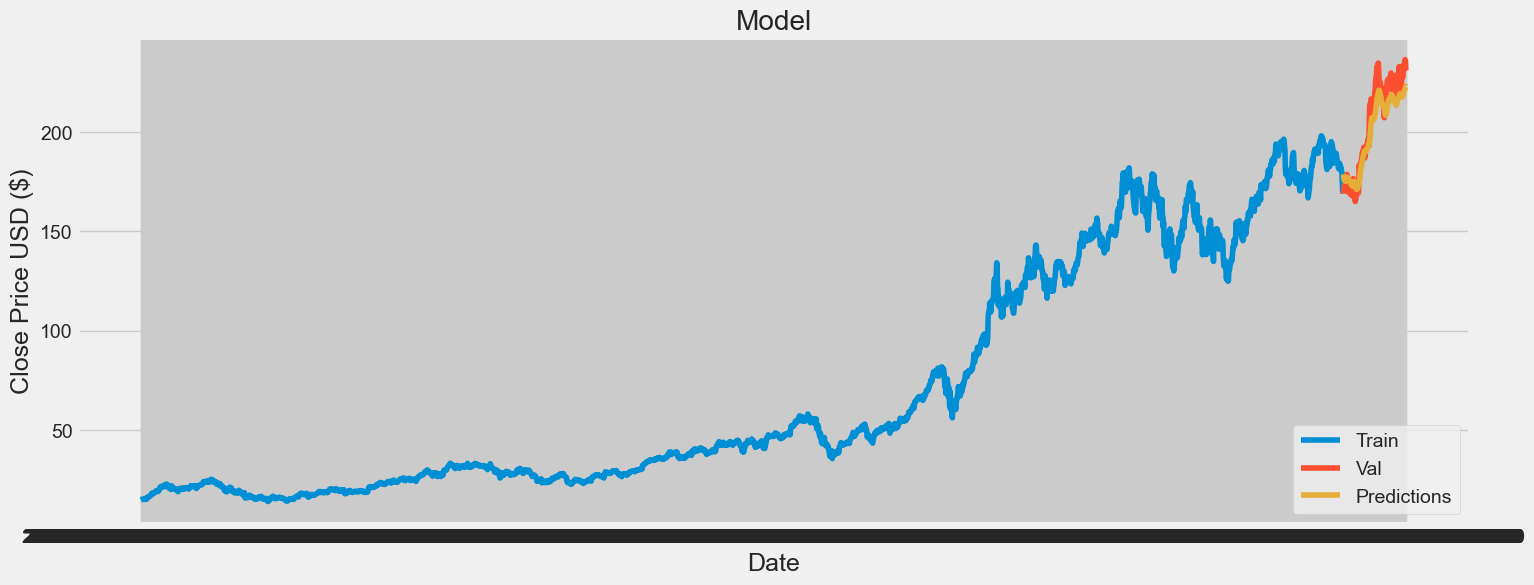

In [18]:
# 시각화
plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()


- 스케일링 된 마지막 날 데이터를 가져와서 예측을 수행
- inverse_trasfrom을 사용해서 스케일링을 된걸 다시 되돌리기 

In [ ]:
last_60_days = scaled_data[-60:]  
next_day_input = last_60_days.reshape((1, 60, 1))  

with torch.no_grad():
    next_day_prediction = model(torch.FloatTensor(next_day_input))

next_day_prediction = scaler.inverse_transform(next_day_prediction.numpy())

print("예측값:", next_day_prediction[0][0])

In [148]:
date_range_list = [
    "2024-10-25",
    "2024-10-28",
    "2024-10-29",
    "2024-10-30",
    "2024-10-31",
    "2024-11-01",
    "2024-11-04",
    "2024-11-05",
    "2024-11-06",
    "2024-11-07",
    "2024-11-08",
    "2024-11-11",
    "2024-11-12",
    "2024-11-13",
    "2024-11-14",
    "2024-11-15",
    "2024-11-18",
    "2024-11-19",
    "2024-11-20",
    "2024-11-21",
    "2024-11-22",
    "2024-11-25",
    "2024-11-26",
    "2024-11-27",
    "2024-11-29",
    "2024-12-02",
    "2024-12-03",
    "2024-12-04",
    "2024-12-05",
    "2024-12-06",
    "2024-12-09",
    "2024-12-10",
    "2024-12-11",
    "2024-12-12",
    "2024-12-13",
    "2024-12-16",
    "2024-12-17",
    "2024-12-18",
    "2024-12-19",
    "2024-12-20",
    "2024-12-23",
    "2024-12-24",
    "2024-12-26",
    "2024-12-27",
    "2024-12-30",
    "2024-12-31"
]

- 처음 입력 시퀀스를 설정 
- 초기 예측값을 업데이트 시키고 새 예측값을 뽑는다 
    * 마지막까지로 해서 60일 하고 , 61일 예측값을 62일 예측값으로 사용 
- 제일 처음을 예측하고 난뒤에 저장하고 제일 앞의 값을 지우고 , 예측값이랑 합쳐서 새로운 sequence를 생성 

In [162]:
last_60_days = scaled_data[-60:] 
input_sequence = last_60_days.reshape((1, 60, 1))

predictions = []

for _ in range(len(date_range_list)):
    with torch.no_grad():
        next_day_prediction = model(torch.FloatTensor(input_sequence))
        
        predictions.append(next_day_prediction.numpy()[0][0])
        
        next_day_prediction = next_day_prediction.numpy()[0][0]
        
        new_input = np.append(input_sequence[0, 1:, :], [[next_day_prediction]], axis=0) 
        input_sequence = new_input.reshape((1, 60, 1))  

predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

predicted_prices_rounded = np.round(predicted_prices)


In [ ]:
print("Next week predictions (original scale):", predicted_prices_rounded.flatten(),len(predicted_prices_rounded))

In [ ]:
# 데이터프레임 생성
predicted_df = pd.DataFrame({
    'date': date_range_list,
    'predicted': predicted_prices_rounded.flatten()
})

# CSV 파일로 저장
predicted_df.to_csv('predicted_stock_60.csv', index=False)
print('완료')

In [ ]:
predicted_df.tail()

In [ ]:
# !pip install pymysql

- 추론 함수 구현 

In [26]:
import joblib

- 모델 스케일러 저장

In [28]:
def save_model_and_scaler(model, scaler, model_path='lstm_model.pth', scaler_path='scaler.pkl'):
    torch.save(model.state_dict(), model_path)
    joblib.dump(scaler, scaler_path)

In [29]:
save_model_and_scaler(model, scaler)

- 하루 예측 함수 
- 매일 최신데이터로 다음날을 예측해볼수 있을 거 같음

In [35]:
def predict_next_day(model, scaler, ticker, prediction_date):
    # 예측날 이전의 60일 데이터 
    end_date = prediction_date
    start_date = end_date - timedelta(days=100) 
    
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    
    # 종가('close')만 필터링 
    data = data[['Close']]
    dataset = data.values

    scaled_data = scaler.transform(dataset)
    
    last_60_days = scaled_data[-60:]
    next_day_input = last_60_days.reshape((1, 60, 1))
    
    model.eval()
    with torch.no_grad():
        next_day_prediction = model(torch.FloatTensor(next_day_input))
    
    next_day_prediction = scaler.inverse_transform(next_day_prediction.numpy())
    return next_day_prediction[0][0]

In [ ]:
prediction_date = datetime(2024, 10, 25) 
predicted_value = predict_next_day(model, scaler, 'AAPL', prediction_date)

In [ ]:
predicted_value

In [ ]:
'''
def save_model_and_scaler(model, scaler, model_path='lstm_model.pth', scaler_path='scaler.pkl'):
    torch.save(model.state_dict(), model_path)
    joblib.dump(scaler, scaler_path)

save_model_and_scaler(model, scaler)
'''

In [43]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dense1 = nn.Linear(64, 25)
        self.dense2 = nn.Linear(25, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.dense1(out[:, -1, :])
        out = self.dense2(out)
        return out

In [44]:
def load_model_and_scaler(model_path='lstm_model.pth', scaler_path='scaler.pkl'):
    model = LSTM()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # 모델을 평가 모드로 설정
    scaler = joblib.load(scaler_path)
    return model, scaler

In [45]:
def predict_next_day(model, scaler, ticker, prediction_date):
    # 예측날 이전의 60일 데이터 
    end_date = prediction_date
    start_date = end_date - timedelta(days=100) 
    
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    
    # 종가('close')만 필터링 
    data = data[['Close']]
    dataset = data.values

    scaled_data = scaler.transform(dataset)
    
    last_60_days = scaled_data[-60:]
    next_day_input = last_60_days.reshape((1, 60, 1))
    
    model.eval()
    with torch.no_grad():
        next_day_prediction = model(torch.FloatTensor(next_day_input))
    
    next_day_prediction = scaler.inverse_transform(next_day_prediction.numpy())
    return next_day_prediction[0][0]

In [46]:
model, scaler = load_model_and_scaler()

C:\Users\a\AppData\Local\Temp\ipykernel_21492\4184368703.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [47]:
prediction_date = datetime(2024, 10, 25)  # 예측하고 싶은 날짜 입력
predicted_value = predict_next_day(model, scaler, 'AAPL', prediction_date)
print("예측값:", predicted_value)

[*********************100%***********************]  1 of 1 completed

예측값: 230.4112
